# **Assignment Instructions:**

**CNN on CIFR Assignment:**

1.  Please visit this link to access the state-of-art DenseNet code for reference - DenseNet - cifar10 notebook link
2.  You need to create a copy of this and "retrain" this model to achieve 90+ test accuracy. 
3.  You cannot use DropOut layers.
4.  You MUST use Image Augmentation Techniques.
5.  You cannot use an already trained model as a beginning points, you have to initilize as your own
6.  You cannot run the program for more than 300 Epochs, and it should be clear from your log, that you have only used 300 Epochs
7.  You cannot use test images for training the model.
8.  You cannot change the general architecture of DenseNet (which means you must use Dense Block, Transition and Output blocks as mentioned in the code)
9.  You are free to change Convolution types (e.g. from 3x3 normal convolution to Depthwise Separable, etc)
10. You cannot have more than 1 Million parameters in total
11. You are free to move the code from Keras to Tensorflow, Pytorch, MXNET etc. 
12. You can use any optimization algorithm you need. 
13. You can checkpoint your model and retrain the model from that checkpoint so that no need of training the model from first if you lost at any epoch while training. You can directly load that model and Train from that epoch. 

# **Importing Libraries & Callbacks:**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import keras
# from keras.datasets import cifar10
# from keras.models import Model, Sequential
# from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
# from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
# from keras.layers import Concatenate
# from keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten, Conv2D
from tensorflow.keras.optimizers import Adam, RMSprop

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
session = tf.compat.v1.Session(config=config)

In [ ]:
#https://stackoverflow.com/questions/39779710/setting-up-a-learningratescheduler-in-keras
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
def scheduler(epoch, lr):
  if epoch % 10 ==0:
    return lr*0.95
  else:
    return lr
lr_scheduler = LearningRateScheduler(scheduler, verbose=1)


#earlystop = EarlyStopping(monitor='accuracy', patience=50, verbose=1)
decay_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.9, patience=10, 
                                                verbose=0, mode='auto', min_delta=0.001, 
                                                cooldown=0, min_lr=1e-6)


#callback_list = [lr_scheduler, decay_lr, checkpoint, tensorboard_callback]


In [ ]:
#Reference:https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
# plot diagnostic learning curves
import matplotlib.pyplot as plt
def summarize_diagnostics(history):
  #plot Loss
  plt.figure(figsize=(10,10))
  plt.subplot(211)
  plt.title('Cross Entropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='test')
  plt.xlabel("Epochs")

  # plot accuracy
  plt.subplot(212)
  plt.title('Classification Accuracy')
  plt.plot(history.history['accuracy'], color='blue', label='train')
  plt.plot(history.history['val_accuracy'], color='orange', label='test')
  plt.xlabel("Epochs")

  plt.show()

**Importing various optimizers for experiment:**

In [ ]:
import tensorflow as tf
optimizer_SGD = tf.keras.optimizers.SGD(
    learning_rate=0.01, momentum=0.7, nesterov=True, 
    name='SGD')

optimizer_aadam = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')

optimizer_adamax = tf.keras.optimizers.Adamax(
    learning_rate=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-07,
    name='Adamax')

optimizer_RMSprop = tf.keras.optimizers.RMSprop(
    learning_rate=0.001, rho=0.9, momentum=0.8, epsilon=1e-06, centered=False,
    name='RMSprop')

optimizer_adagrad = tf.keras.optimizers.Adagrad(
    learning_rate=0.1, initial_accumulator_value=0.1, epsilon=1e-07,
    name='Adagrad')

optimizer_adadelta = tf.keras.optimizers.Adadelta(
    learning_rate=0.1, rho=0.95, epsilon=1e-07, name='Adadelta')

**Importing Data**

In [ ]:
num_classes=10
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

170508288/170498071 [==============================] - 2s 0us/step


# **Given Model:** Baseline Model

In [ ]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 10
l = 40
num_filter = 12
compression = 0.5
dropout_rate = 0.2

In [ ]:
X_train.shape

(50000, 32, 32, 3)

In [ ]:
X_test.shape

(10000, 32, 32, 3)

In [ ]:
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    return output

In [ ]:
num_filter = 32
dropout_rate = 0.2
l = 12
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

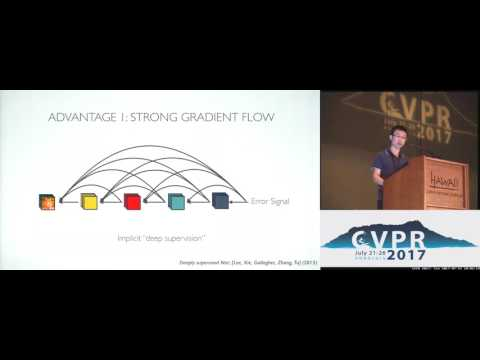

In [ ]:
#https://arxiv.org/pdf/1608.06993.pdf
from IPython.display import IFrame, YouTubeVideo
YouTubeVideo(id='-W6y8xnd--U', width=600)

In [ ]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 32)   0           ['batch_normalization[0][0]']

In [ ]:
print(len(model.layers))

262


In [ ]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=15,
                    verbose=1, 
                    validation_data=(X_test, y_test))

Epoch 1/15
391/391 [==============================] - 63s 123ms/step - loss: 1.5028 - accuracy: 0.4407 - val_loss: 1.3083 - val_accuracy: 0.5462
Epoch 2/15
391/391 [==============================] - 46s 118ms/step - loss: 1.0619 - accuracy: 0.6156 - val_loss: 1.0897 - val_accuracy: 0.6273
Epoch 3/15
391/391 [==============================] - 46s 118ms/step - loss: 0.8823 - accuracy: 0.6860 - val_loss: 1.2462 - val_accuracy: 0.6174
Epoch 4/15
391/391 [==============================] - 46s 118ms/step - loss: 0.7728 - accuracy: 0.7267 - val_loss: 1.2038 - val_accuracy: 0.6291
Epoch 5/15
391/391 [==============================] - 46s 118ms/step - loss: 0.6914 - accuracy: 0.7566 - val_loss: 1.0449 - val_accuracy: 0.6720
Epoch 6/15
391/391 [==============================] - 46s 118ms/step - loss: 0.6316 - accuracy: 0.7786 - val_loss: 1.2943 - val_accuracy: 0.6589
Epoch 7/15
391/391 [==============================] - 46s 118ms/step - loss: 0.5857 - accuracy: 0.7967 - val_loss: 0.9262 - val_ac

313/313 [==============================] - 4s 11ms/step - loss: 0.9087 - accuracy: 0.7570
Test loss: 0.9087499976158142
Test accuracy: 0.7570000290870667
--------------------------------------------------


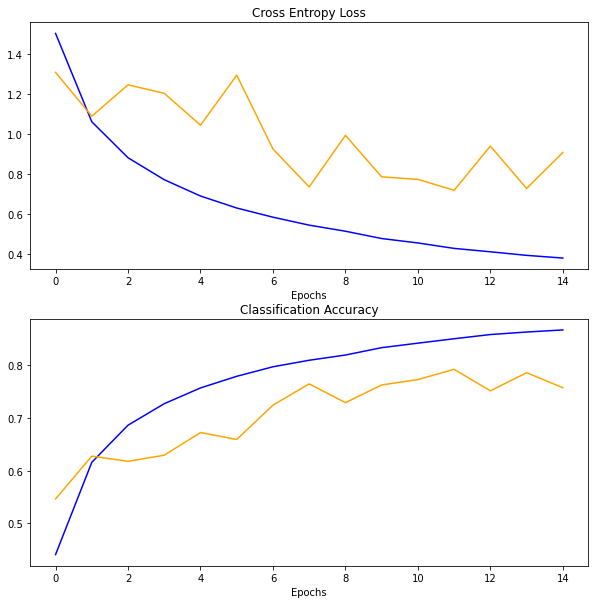

In [ ]:
# Testing the model
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print("--"*25)


summarize_diagnostics(history)

In [ ]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model.h5")
print("Saved model to disk")

Saved model to disk


_________________________________________________________________

# **Model 1:** Depthwise Seperable Conv2D + without Dropout + Without Dense Layer + Image Augmentation + SGD + Weight Regularizer(L1+L2).

In [ ]:
tf.keras.backend.clear_session()

if 'model' in locals():
  del(model)

In [ ]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs =100
l = 12
num_filter = 36
compression = 0.5
dropout_rate = 0.0

In [ ]:
# Dense Block
def denseblock(input, num_filter = num_filter, dropout_rate = dropout_rate):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.SeparableConv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same', 
                                   kernel_initializer='he_normal',kernel_regularizer=regularizers.L1L2(l1=0.000001, l2=0.00001))(relu)
        #Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = num_filter, dropout_rate = dropout_rate):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.SeparableConv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same',  
                                               depthwise_initializer='he_normal', depthwise_regularizer=regularizers.L1L2(l1=0.0001, l2=0.0001),
                                               kernel_regularizer=regularizers.L2(l2=0.001))(relu)
    #Conv2D_BottleNeck =  Conv2D(int(num_filter*compression), (1,1), use_bias=False, kernel_regularizer = regularizers.l1() ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    #flat = layers.Flatten()(AvgPooling)
    #output = layers.Dense(num_classes, activation='softmax')(flat)
    out_conv = layers.Conv2D(num_classes, kernel_size = (2,2), activation='softmax')(AvgPooling)
    output = layers.Flatten()(out_conv)


    return output

In [ ]:
#Model Architecture
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)
#First_Conv2D = layers.SeparableConv2D(int(num_filter), (3,3), use_bias=True ,padding='same', 
                                      #kernel_regularizer=regularizers.L1L2(l1=0.0001, l2=0.0001))(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

model = Model(inputs=[input], outputs=[output])


In [ ]:
# mormalize data
#X_train = X_train.astype('float32') / 255
#X_test = X_test.astype('float32') / 255

In [ ]:
###Image data Generator class
datagen = tf.keras.preprocessing.image.ImageDataGenerator(featurewise_center=False,  
                                                          samplewise_center=False, 
                                                          featurewise_std_normalization=False, 
                                                          samplewise_std_normalization=False,  
                                                          zca_whitening=False,  
                                                          rotation_range=15, 
                                                          width_shift_range=0.1, 
                                                          height_shift_range=0.1,  
                                                          horizontal_flip=True,  
                                                          vertical_flip=False , zoom_range=0.2, shear_range=15)
##We are fitting the data to Image data generator.
#ImageGenerator = ImageFlow.flow(X_train,seed=10,batch_size=32)
datagen.fit(X_train, augment=False )

In [ ]:
#Saving Best Model and Representation of results
filepath = "/content/drive/MyDrive/27 CNN on CIFR/Model Output/model_7_Rev01_depthwise.h5"
checkpoint = ModelCheckpoint(filepath= filepath, save_weights_only=True,
                              monitor='val_accuracy', verbose=1,
                              save_best_only=True, mode='max') 

log_dir = "logs/model_7_Rev01_depthwise"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq=1)
#callback_list = [checkpoint, tensorboard_callback, decay_lr]

#Model Compilation
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(0.01, momentum = 0.7),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 36)   972         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 36)  144         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 36)   0           ['batch_normalization[0][0]']

In [ ]:
def lr_schedule(epoch):
    lr = 0.01
    if epoch > 180:
        lr *= 0.00001
    elif epoch > 180:
        lr *= 0.0001
    elif epoch > 120:
        lr *= 0.001
    print('\nLearning rate: ', lr)
    return lr
lr_scheduler = LearningRateScheduler(lr_schedule)


In [ ]:
epochs = 30

decay_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.95, patience=5, 
                                                verbose=1, mode='auto', min_delta=0.001, 
                                                cooldown=0, min_lr=0.000001)

callback_list = [checkpoint, lr_scheduler]

history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=X_train.shape[0] // batch_size, epochs=epochs,\
                    verbose=1,validation_data=(X_test,y_test),callbacks=callback_list)

model.save_weights('/content/drive/MyDrive/27 CNN on CIFR/Model Output/model_7_30Epoch_Rev01_depthwise.h5')


Learning rate:  0.01
Epoch 1/30
390/390 [==============================] - ETA: 0s - loss: 1.6673 - accuracy: 0.3875
Epoch 00001: val_accuracy improved from -inf to 0.12760, saving model to /content/drive/MyDrive/27 CNN on CIFR/Model Output/model_7_Rev01.h5
390/390 [==============================] - 66s 155ms/step - loss: 1.6673 - accuracy: 0.3875 - val_loss: 2.3530 - val_accuracy: 0.1276 - lr: 0.0100

Learning rate:  0.01
Epoch 2/30
390/390 [==============================] - ETA: 0s - loss: 1.3880 - accuracy: 0.5001
Epoch 00002: val_accuracy improved from 0.12760 to 0.46130, saving model to /content/drive/MyDrive/27 CNN on CIFR/Model Output/model_7_Rev01.h5
390/390 [==============================] - 59s 152ms/step - loss: 1.3880 - accuracy: 0.5001 - val_loss: 1.5488 - val_accuracy: 0.4613 - lr: 0.0100

Learning rate:  0.01
Epoch 3/30
390/390 [==============================] - ETA: 0s - loss: 1.2415 - accuracy: 0.5559
Epoch 00003: val_accuracy improved from 0.46130 to 0.49820, saving 

313/313 [==============================] - 4s 12ms/step - loss: 0.5894 - accuracy: 0.8044
Test loss: 0.5894258618354797
Test accuracy: 0.8044000267982483
--------------------------------------------------


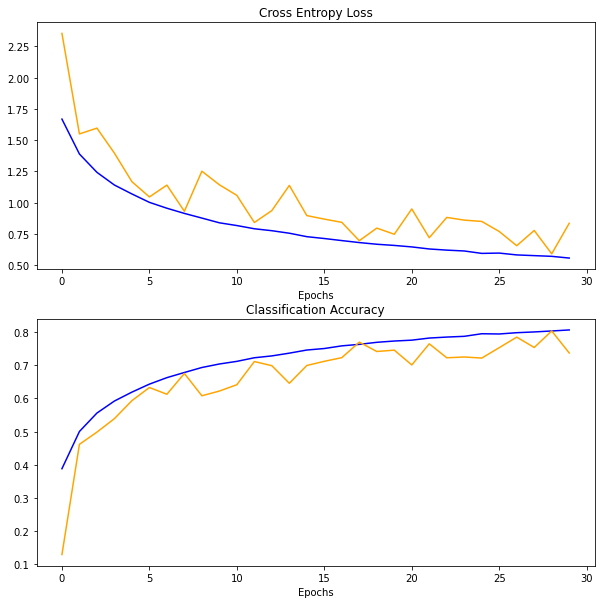

In [ ]:
# Testing the model- Best Model
model.load_weights('/content/drive/MyDrive/27 CNN on CIFR/Model Output/model_7_Rev01.h5')
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print("--"*25)


summarize_diagnostics(history)

▶ **Loading Model from 100th Epoch for further Training:**

In [ ]:
import tensorflow.keras.backend as k
k.set_value(model.optimizer.lr, 0.01)

callback_list = [checkpoint]
model.load_weights('/content/drive/MyDrive/27 CNN on CIFR/Model Output/model_7_30Epoch_Rev01_depthwise.h5')
epochs = 60
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=X_train.shape[0] // batch_size,epochs=epochs,\
                    verbose=1,validation_data=(X_test,y_test),callbacks=callback_list)

model.save_weights('/content/drive/MyDrive/27 CNN on CIFR/Model Output/model_7_90Epoch_Rev01_depthwise.h5')

Epoch 1/60
390/390 [==============================] - ETA: 0s - loss: 0.5568 - accuracy: 0.8081
Epoch 00001: val_accuracy did not improve from 0.80440
390/390 [==============================] - 59s 151ms/step - loss: 0.5568 - accuracy: 0.8081 - val_loss: 0.6223 - val_accuracy: 0.7954
Epoch 2/60
390/390 [==============================] - ETA: 0s - loss: 0.5425 - accuracy: 0.8139
Epoch 00002: val_accuracy did not improve from 0.80440
390/390 [==============================] - 59s 150ms/step - loss: 0.5425 - accuracy: 0.8139 - val_loss: 0.6359 - val_accuracy: 0.7921
Epoch 3/60
390/390 [==============================] - ETA: 0s - loss: 0.5372 - accuracy: 0.8150
Epoch 00003: val_accuracy did not improve from 0.80440
390/390 [==============================] - 58s 150ms/step - loss: 0.5372 - accuracy: 0.8150 - val_loss: 0.6458 - val_accuracy: 0.7857
Epoch 4/60
390/390 [==============================] - ETA: 0s - loss: 0.5257 - accuracy: 0.8170
Epoch 00004: val_accuracy did not improve from 0.

▶ **Training Model further from 115th Epoch :**
<br>Let's try changing learning rate

In [ ]:
import tensorflow.keras.backend as k
k.set_value(model.optimizer.lr, 0.01)
callback_list = [checkpoint]
model.load_weights('/content/drive/MyDrive/27 CNN on CIFR/Model Output/model_7_90Epoch_Rev01_depthwise.h5')

epochs = 30
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=X_train.shape[0] // batch_size,epochs=epochs,\
                    verbose=1,validation_data=(X_test,y_test),callbacks=callback_list)

model.save_weights('/content/drive/MyDrive/27 CNN on CIFR/Model Output/model_7_120Epoch_Rev01_depthwise.h5')

Epoch 1/30
390/390 [==============================] - ETA: 0s - loss: 0.3416 - accuracy: 0.8836
Epoch 00001: val_accuracy improved from 0.86320 to 0.87060, saving model to /content/drive/MyDrive/27 CNN on CIFR/Model Output/model_7_Rev01.h5
390/390 [==============================] - 59s 152ms/step - loss: 0.3416 - accuracy: 0.8836 - val_loss: 0.4056 - val_accuracy: 0.8706
Epoch 2/30
390/390 [==============================] - ETA: 0s - loss: 0.3406 - accuracy: 0.8837
Epoch 00002: val_accuracy did not improve from 0.87060
390/390 [==============================] - 59s 150ms/step - loss: 0.3406 - accuracy: 0.8837 - val_loss: 0.5601 - val_accuracy: 0.8282
Epoch 3/30
390/390 [==============================] - ETA: 0s - loss: 0.3434 - accuracy: 0.8824
Epoch 00003: val_accuracy did not improve from 0.87060
390/390 [==============================] - 59s 151ms/step - loss: 0.3434 - accuracy: 0.8824 - val_loss: 0.5448 - val_accuracy: 0.8301
Epoch 4/30
390/390 [==============================] - ET

In [ ]:
import tensorflow.keras.backend as k
k.set_value(model.optimizer.lr, 0.001)

model.load_weights('/content/drive/MyDrive/27 CNN on CIFR/Model Output/model_7_120Epoch_Rev01_depthwise.h5')

epochs = 60
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=X_train.shape[0] // batch_size,epochs=epochs,\
                    verbose=1,validation_data=(X_test,y_test),callbacks=callback_list)

model.save_weights('/content/drive/MyDrive/27 CNN on CIFR/Model Output/model_7_180Epoch_Rev01_depthwise.h5')

Epoch 1/60
390/390 [==============================] - ETA: 0s - loss: 0.2677 - accuracy: 0.9087
Epoch 00001: val_accuracy improved from 0.87060 to 0.88380, saving model to /content/drive/MyDrive/27 CNN on CIFR/Model Output/model_7_Rev01.h5
390/390 [==============================] - 59s 152ms/step - loss: 0.2677 - accuracy: 0.9087 - val_loss: 0.3748 - val_accuracy: 0.8838
Epoch 2/60
390/390 [==============================] - ETA: 0s - loss: 0.2577 - accuracy: 0.9133
Epoch 00002: val_accuracy did not improve from 0.88380
390/390 [==============================] - 58s 150ms/step - loss: 0.2577 - accuracy: 0.9133 - val_loss: 0.3791 - val_accuracy: 0.8824
Epoch 3/60
390/390 [==============================] - ETA: 0s - loss: 0.2566 - accuracy: 0.9140
Epoch 00003: val_accuracy improved from 0.88380 to 0.88520, saving model to /content/drive/MyDrive/27 CNN on CIFR/Model Output/model_7_Rev01.h5
390/390 [==============================] - 59s 152ms/step - loss: 0.2566 - accuracy: 0.9140 - val_los

In [ ]:
import tensorflow.keras.backend as k
k.set_value(model.optimizer.lr, 0.0001)

#Model Compilation
#model.compile(loss='categorical_crossentropy',
              #optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-06, amsgrad=True, name='Adam'),
              #metrics=['accuracy'])

model.load_weights('/content/drive/MyDrive/27 CNN on CIFR/Model Output/model_7_180Epoch_Rev01_depthwise.h5')
callback_list = [checkpoint]
epochs = 30
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=X_train.shape[0] // batch_size,epochs=epochs,\
                    verbose=1,validation_data=(X_test,y_test),callbacks=callback_list)

model.save_weights('/content/drive/MyDrive/27 CNN on CIFR/Model Output/model_7_210Epoch_Rev01_depthwise.h5')

Epoch 1/30
390/390 [==============================] - ETA: 0s - loss: 0.2227 - accuracy: 0.9241
Epoch 00001: val_accuracy improved from -inf to 0.88980, saving model to /content/drive/MyDrive/27 CNN on CIFR/Model Output/model_7_Rev01_depthwise.h5
390/390 [==============================] - 68s 156ms/step - loss: 0.2227 - accuracy: 0.9241 - val_loss: 0.3760 - val_accuracy: 0.8898
Epoch 2/30
390/390 [==============================] - ETA: 0s - loss: 0.2249 - accuracy: 0.9241
Epoch 00002: val_accuracy improved from 0.88980 to 0.89020, saving model to /content/drive/MyDrive/27 CNN on CIFR/Model Output/model_7_Rev01_depthwise.h5
390/390 [==============================] - 59s 152ms/step - loss: 0.2249 - accuracy: 0.9241 - val_loss: 0.3734 - val_accuracy: 0.8902
Epoch 3/30
390/390 [==============================] - ETA: 0s - loss: 0.2256 - accuracy: 0.9234
Epoch 00003: val_accuracy did not improve from 0.89020
390/390 [==============================] - 58s 149ms/step - loss: 0.2256 - accuracy:

In [ ]:
import tensorflow.keras.backend as k
k.set_value(model.optimizer.lr, 0.0001)


decay_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.99, patience= 5, 
                                                verbose=1, mode='auto', min_delta=0.001, 
                                                cooldown=0, min_lr=0.000001)

callback_list = [checkpoint]


model.load_weights('/content/drive/MyDrive/27 CNN on CIFR/Model Output/model_7_210Epoch_Rev01_depthwise.h5')

epochs = 90
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=0.05*X_train.shape[0] // batch_size,epochs=epochs,\
                    verbose=1,validation_data=(X_test,y_test),callbacks=callback_list)

model.save_weights('/content/drive/MyDrive/27 CNN on CIFR/Model Output/model_7_300Epoch_Rev01_depthwise.h5')

Epoch 1/90
19/19 [==============================] - ETA: 0s - loss: 0.1987 - accuracy: 0.9387
Epoch 00001: val_accuracy improved from 0.89170 to 0.89250, saving model to /content/drive/MyDrive/27 CNN on CIFR/Model Output/model_7_Rev01_depthwise.h5
19/19 [==============================] - 7s 362ms/step - loss: 0.1987 - accuracy: 0.9387 - val_loss: 0.3623 - val_accuracy: 0.8925
Epoch 2/90
19/19 [==============================] - ETA: 0s - loss: 0.2205 - accuracy: 0.9248
Epoch 00002: val_accuracy did not improve from 0.89250
19/19 [==============================] - 6s 317ms/step - loss: 0.2205 - accuracy: 0.9248 - val_loss: 0.3637 - val_accuracy: 0.8921
Epoch 3/90
19/19 [==============================] - ETA: 0s - loss: 0.2162 - accuracy: 0.9268
Epoch 00003: val_accuracy did not improve from 0.89250
19/19 [==============================] - 6s 320ms/step - loss: 0.2162 - accuracy: 0.9268 - val_loss: 0.3645 - val_accuracy: 0.8913
Epoch 4/90
19/19 [==============================] - ETA: 0s -

# **Model 2:** Depthwise Seperable Conv2D + without Dropout + Without Dense Layer + Image Augmentation + SGD + Weight Regularizer(L1+L2).

ADAM performs better than SGD ir seems. Let's using **more filters + bias=True + increased kernel size.**

In [ ]:
tf.keras.backend.clear_session()

if 'model' in locals():
  del(model)

In [ ]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs =100
l = 24
num_filter = 36
compression = 0.5
dropout_rate = 0.0

In [ ]:
# Dense Block
def denseblock(input, num_filter = num_filter, dropout_rate = dropout_rate):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.SeparableConv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same', 
                                   kernel_initializer='he_normal',kernel_regularizer=regularizers.L1L2(l1=0.000001, l2=0.00001))(relu)
        #Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = num_filter, dropout_rate = dropout_rate):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.SeparableConv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same',  
                                               depthwise_initializer='he_normal', depthwise_regularizer=regularizers.L1L2(l1=0.0001, l2=0.0001),
                                               kernel_regularizer=regularizers.L2(l2=0.001))(relu)
    #Conv2D_BottleNeck =  Conv2D(int(num_filter*compression), (1,1), use_bias=False, kernel_regularizer = regularizers.l1() ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    #flat = layers.Flatten()(AvgPooling)
    #output = layers.Dense(num_classes, activation='softmax')(flat)
    out_conv = layers.Conv2D(num_classes, kernel_size = (2,2), activation='softmax')(AvgPooling)
    output = layers.Flatten()(out_conv)


    return output

In [ ]:
#Model Architecture
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)
#First_Conv2D = layers.SeparableConv2D(int(num_filter), (3,3), use_bias=True ,padding='same', 
                                      #kernel_regularizer=regularizers.L1L2(l1=0.0001, l2=0.0001))(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

model = Model(inputs=[input], outputs=[output])


In [ ]:
# mormalize data
#X_train = X_train.astype('float32') / 255
#X_test = X_test.astype('float32') / 255

In [ ]:
###Image data Generator class
datagen = tf.keras.preprocessing.image.ImageDataGenerator(featurewise_center=False, 
                                                          samplewise_center=False,  
                                                          featurewise_std_normalization=False,  
                                                          samplewise_std_normalization=False,  
                                                          zca_whitening=False, 
                                                          rotation_range=15, 
                                                          width_shift_range=0.1,
                                                          height_shift_range=0.1,  
                                                          horizontal_flip=True,  
                                                          vertical_flip=False , zoom_range=0.2, shear_range=15)
##We are fitting the data to Image data generator.
#ImageGenerator = ImageFlow.flow(X_train,seed=10,batch_size=32)
datagen.fit(X_train, augment=False )

In [ ]:
#Saving Best Model and Representation of results
filepath = "/content/drive/MyDrive/27 CNN on CIFR/Model Output/model_depthwise_best.h5"
checkpoint = ModelCheckpoint(filepath= filepath, save_weights_only=True,
                              monitor='val_accuracy', verbose=1,
                              save_best_only=True, mode='max') 

log_dir = "logs/model_depthwise"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq=1)
#callback_list = [checkpoint, tensorboard_callback, decay_lr]

#Model Compilation
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(0.01, momentum = 0.7),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 36)   972         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 36)  144         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 36)   0           ['batch_normalization[0][0]']

In [ ]:
def lr_schedule(epoch):
    lr = 0.01
    if epoch > 180:
        lr *= 0.00001
    elif epoch > 180:
        lr *= 0.0001
    elif epoch > 120:
        lr *= 0.001
    print('\nLearning rate: ', lr)
    return lr
lr_scheduler = LearningRateScheduler(lr_schedule)


In [ ]:
epochs = 120

decay_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.95, patience=5, 
                                                verbose=1, mode='auto', min_delta=0.001, 
                                                cooldown=0, min_lr=0.000001)

callback_list = [checkpoint]

history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=X_train.shape[0] // batch_size, epochs=epochs,\
                    verbose=1,validation_data=(X_test,y_test),callbacks=callback_list)

model.save_weights('/content/drive/MyDrive/27 CNN on CIFR/Model Output/model_depthwise_120Epoch.h5')

Epoch 1/120
390/390 [==============================] - ETA: 0s - loss: 1.6611 - accuracy: 0.3933
Epoch 00001: val_accuracy improved from -inf to 0.10000, saving model to /content/drive/MyDrive/27 CNN on CIFR/Model Output/model_depthwise_best.h5
390/390 [==============================] - 213s 488ms/step - loss: 1.6611 - accuracy: 0.3933 - val_loss: 2.4854 - val_accuracy: 0.1000
Epoch 2/120
390/390 [==============================] - ETA: 0s - loss: 1.3546 - accuracy: 0.5116
Epoch 00002: val_accuracy improved from 0.10000 to 0.44030, saving model to /content/drive/MyDrive/27 CNN on CIFR/Model Output/model_depthwise_best.h5
390/390 [==============================] - 186s 476ms/step - loss: 1.3546 - accuracy: 0.5116 - val_loss: 1.5931 - val_accuracy: 0.4403
Epoch 3/120
390/390 [==============================] - ETA: 0s - loss: 1.1941 - accuracy: 0.5744
Epoch 00003: val_accuracy improved from 0.44030 to 0.58190, saving model to /content/drive/MyDrive/27 CNN on CIFR/Model Output/model_depthwi

313/313 [==============================] - 10s 31ms/step - loss: 0.3927 - accuracy: 0.8842
Test loss: 0.39271241426467896
Test accuracy: 0.8841999769210815
--------------------------------------------------


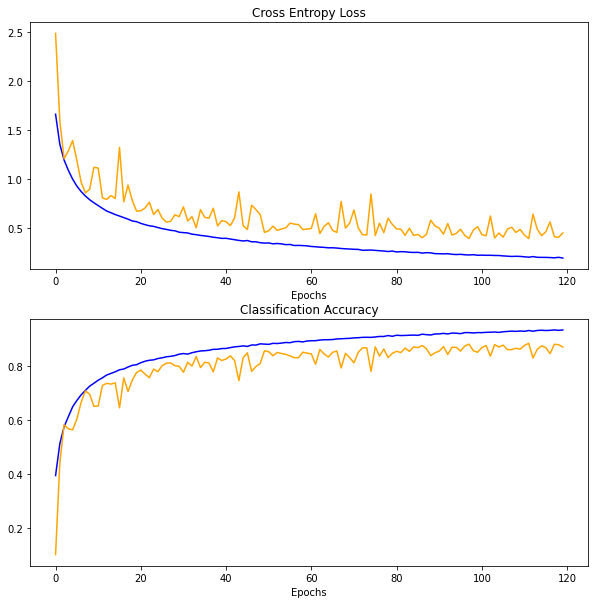

In [ ]:
# Testing the model- Best Model
model.load_weights('/content/drive/MyDrive/27 CNN on CIFR/Model Output/model_depthwise_best.h5')
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print("--"*25)


summarize_diagnostics(history)

▶ **Loading Model from 120th Epoch for further Training:**

In [ ]:
import tensorflow.keras.backend as k
k.set_value(model.optimizer.lr, 0.001)

callback_list = [checkpoint]
model.load_weights('/content/drive/MyDrive/27 CNN on CIFR/Model Output/model_depthwise_120Epoch.h5')
epochs = 60
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=X_train.shape[0] // batch_size,epochs=epochs,\
                    verbose=1,validation_data=(X_test,y_test),callbacks=callback_list)

model.save_weights('/content/drive/MyDrive/27 CNN on CIFR/Model Output/model_depthwise_180Epoch.h5')

Epoch 1/60
390/390 [==============================] - ETA: 0s - loss: 0.1614 - accuracy: 0.9471
Epoch 00001: val_accuracy improved from 0.88420 to 0.89430, saving model to /content/drive/MyDrive/27 CNN on CIFR/Model Output/model_depthwise_best.h5
390/390 [==============================] - 186s 477ms/step - loss: 0.1614 - accuracy: 0.9471 - val_loss: 0.3525 - val_accuracy: 0.8943
Epoch 2/60
390/390 [==============================] - ETA: 0s - loss: 0.1478 - accuracy: 0.9517
Epoch 00002: val_accuracy improved from 0.89430 to 0.89690, saving model to /content/drive/MyDrive/27 CNN on CIFR/Model Output/model_depthwise_best.h5
390/390 [==============================] - 186s 477ms/step - loss: 0.1478 - accuracy: 0.9517 - val_loss: 0.3574 - val_accuracy: 0.8969
Epoch 3/60
390/390 [==============================] - ETA: 0s - loss: 0.1426 - accuracy: 0.9534
Epoch 00003: val_accuracy improved from 0.89690 to 0.89970, saving model to /content/drive/MyDrive/27 CNN on CIFR/Model Output/model_depthwi

**Loading Best Model:**

In [ ]:
import numpy as np
# Testing the model- Rev01 Model
model.load_weights('/content/drive/MyDrive/27 CNN on CIFR/Model Output/model_depthwise_best.h5')
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', np.round(score[0],2))
print('Test accuracy:', np.round(score[1],2))
print("--"*25)

313/313 [==============================] - 9s 30ms/step - loss: 0.3327 - accuracy: 0.9042
Test loss: 0.33
Test accuracy: 0.9
--------------------------------------------------


# **Representation of Results:**


In [48]:
from prettytable import PrettyTable
results = PrettyTable()
results.field_names = ["Model Description", "Total Parameters","Hyperparams","Best Model Accuracy-Train", "Best Model Accuracy-Test"]
results.add_row([ "Depthwise Seperable Conv2D \n + Elastic Net\n" , "208,630", "Epoch   :300\n l      :12 \nfilters:36\n","\n 0.9387", "\n 0.8925" ])
results.add_row([ "Depthwise Seperable Conv2D \n + Elastic Net" , "735,238","Epoch   :144\n l      :24 \nfilters:36\n", "\n 0.9602", "\n 0.9042" ])
print(results)

+-----------------------------+------------------+--------------+---------------------------+--------------------------+
|      Model Description      | Total Parameters | Hyperparams  | Best Model Accuracy-Train | Best Model Accuracy-Test |
+-----------------------------+------------------+--------------+---------------------------+--------------------------+
| Depthwise Seperable Conv2D  |     208,630      | Epoch   :300 |                           |                          |
|         + Elastic Net       |                  |  l      :12  |           0.9387          |          0.8925          |
|                             |                  |  filters:36  |                           |                          |
|                             |                  |              |                           |                          |
| Depthwise Seperable Conv2D  |     735,238      | Epoch   :144 |                           |                          |
|         + Elastic Net       | 

`End`